##Import ต่างๆ

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##ทำการ Read ไฟล์ csv ที่ทางเว็บให้มา

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/ปี3เทอม1/CP462/Final Project/Data/train_ctrUa4K.csv")
test_data = pd.read_csv("/content/drive/MyDrive/ปี3เทอม1/CP462/Final Project/Data/test_lAUu6dG.csv")

In [5]:
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
test_data_copy = test_data.copy()

In [7]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##ขนาดของ Train และ Test

In [8]:
train_data.shape

(614, 13)

In [9]:
test_data.shape

(367, 12)

##ทำการเช็คข้อมูลและทำการ Clean ข้อมูลและทำการเติม Missing 


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


แยกประเภทของข้อมูล

In [11]:
cat_data = []

for index, type in enumerate(train_data.dtypes):
    if type == "object":
        cat_data.append(train_data.iloc[:, index])
cat_data = pd.DataFrame(cat_data).transpose()
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,Urban,Y


In [12]:
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

จะเห็นได้ว่าข้อมูลมี null อยู่ซึ่งอาจจะทำให้การ predict ผิดพลาดได้จึงต้องทำการจัดการกับข้อมูลเสียก่อน


In [13]:
del cat_data['Loan_ID']
del cat_data['Self_Employed']
for cat in cat_data.columns :
  if cat == 'Loan_Status' :
    pass
  else :
    train_data[cat]  = train_data[cat].fillna(train_data[cat].mode()[0])
    test_data[cat] = test_data[cat].fillna(test_data[cat].mode()[0])

In [14]:
train_data.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

LoanAmount fill ด้วย median

In [15]:
test_data.LoanAmount = test_data.LoanAmount.fillna(test_data["LoanAmount"].median())
train_data.LoanAmount = train_data.LoanAmount.fillna(train_data["LoanAmount"].median())

Loan_Amount_Term fill ด้วย bfill

In [16]:
train_data.Loan_Amount_Term = train_data.Loan_Amount_Term.fillna(method="bfill")
test_data.Loan_Amount_Term = test_data.Loan_Amount_Term.fillna(method="bfill")

Loan_Status fill ด้วยการดูค่าจาก Loan_Status เพราะว่าจาก EDA ทำให้ทราบว่าถ้า Credit_History กับ Loan_Status มีความสัมพันธ์กัน

In [17]:
train_data.loc[(train_data.Credit_History.isnull())&(train_data.Loan_Status==1),'Credit_History'] = 1
train_data.loc[(train_data.Credit_History.isnull()),'Credit_History'] = 0

test_data.Credit_History = test_data.Credit_History.fillna(method="bfill")
test_data['Credit_History'].fillna(test_data['Credit_History'].value_counts().index[0], inplace=True)
test_data.loc[(test_data.ApplicantIncome == 2733),'Credit_History']  = 0

จาก EDA ทำให้ทราบว่าส่วนมากถ้าไม่ใช่อาชีพอิสระจะได้ credit_history = 1 

In [18]:
train_data.loc[(train_data.Self_Employed.isnull())&(train_data.Credit_History==1),'Self_Employed'] ='No'
train_data.loc[(train_data.Self_Employed.isnull()),'Self_Employed'] = 'Yes'

test_data.loc[(test_data.Self_Employed.isnull())&(test_data.Credit_History==1),'Self_Employed'] ='No'
test_data.loc[(test_data.Self_Employed.isnull()),'Self_Employed'] = 'Yes'

In [19]:
train_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [20]:
test_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

หลังจากการจัดการข้อมูแล้วจะทำให้เห็นวาไม่มีค่า Null แล้ว

##EDA


In [50]:
train_data_copy = train_data.copy()

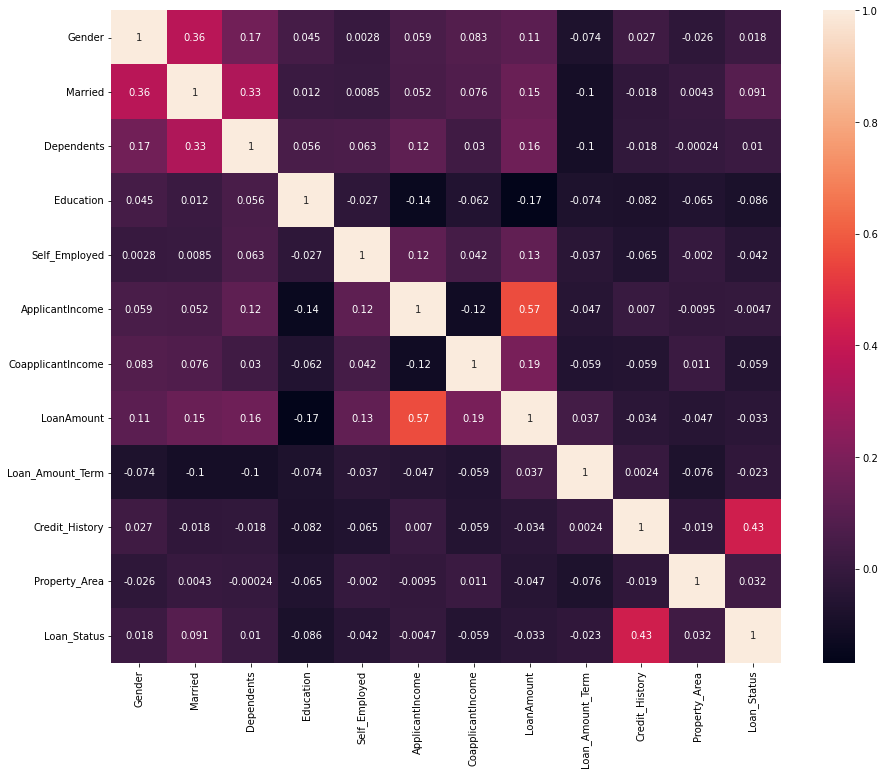

In [51]:
corr = train_data_copy.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True)

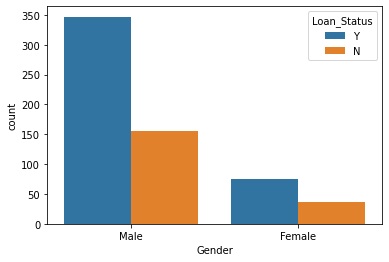

In [22]:
sns.countplot(train_data.Gender,hue=train_data.Loan_Status)

In [23]:
pd.crosstab(train_data.Gender, train_data.Loan_Status, margins = True)

Loan_Status,N,Y,All
Gender,,,
Female,37,75,112
Male,155,347,502
All,192,422,614


ผู้ชายมีจำนวนมากกว่าเมื่อเทียบกับผู้หญิง หลายคนยังมีสถานการกู้เป็น Yes

In [24]:
train_data.Dependents.value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [25]:
pd.crosstab(train_data.Dependents,train_data.Loan_Status , margins=True)

Loan_Status,N,Y,All
Dependents,,,
0,113,247,360
1,36,66,102
2,25,76,101
3+,18,33,51
All,192,422,614


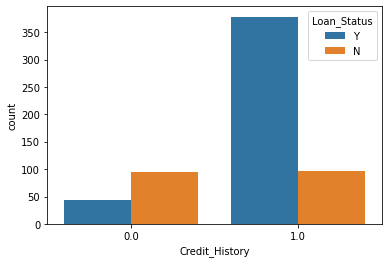

In [26]:
sns.countplot(train_data.Credit_History,hue=train_data.Loan_Status)

In [27]:
pd.crosstab(train_data.Credit_History,train_data.Loan_Status , margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,95,44,139
1.0,97,378,475
All,192,422,614


ถ้าประหยัดเครดิตดีก็จะมีโอกาสที่จะกู้ได้มากกว่า ซึ่งควรนำไปทำเป็น Features

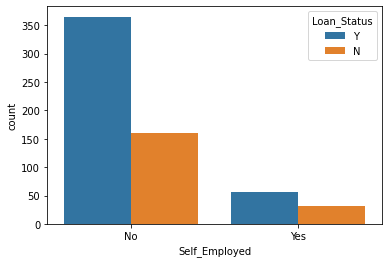

In [28]:
sns.countplot(train_data.Self_Employed,hue=train_data.Loan_Status)

In [29]:
pd.crosstab(train_data.Self_Employed , train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Self_Employed,,,
No,160,365,525
Yes,32,57,89
All,192,422,614


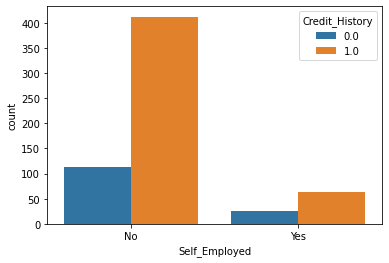

In [30]:
sns.countplot(train_data.Self_Employed,hue=train_data.Credit_History)

In [31]:
pd.crosstab(train_data.Self_Employed , train_data.Credit_History,margins = True)

Credit_History,0.0,1.0,All
Self_Employed,,,
No,113,412,525
Yes,26,63,89
All,139,475,614


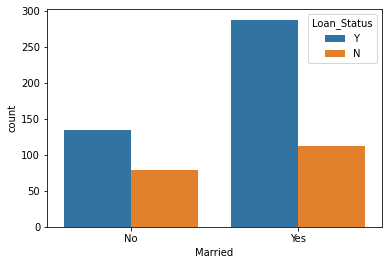

In [32]:
sns.countplot(train_data.Married,hue=train_data.Loan_Status)

In [33]:
pd.crosstab(train_data.Married, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Married,,,
No,79,134,213
Yes,113,288,401
All,192,422,614


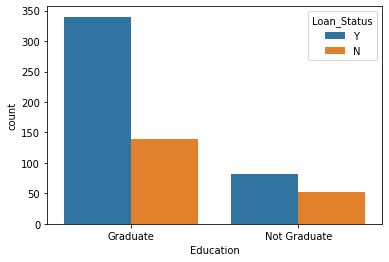

In [34]:
sns.countplot(train_data.Education,hue=train_data.Loan_Status)

In [35]:
pd.crosstab(train_data.Education, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Education,,,
Graduate,140,340,480
Not Graduate,52,82,134
All,192,422,614


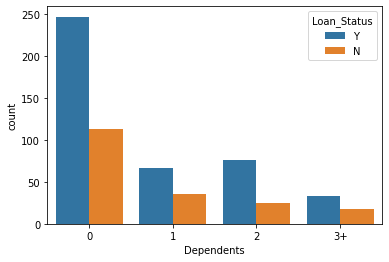

In [36]:
sns.countplot(train_data.Dependents,hue=train_data.Loan_Status)

In [37]:
pd.crosstab(train_data.Dependents, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Dependents,,,
0,113,247,360
1,36,66,102
2,25,76,101
3+,18,33,51
All,192,422,614


##Preprocessing

In [38]:
cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 
        'Loan_Status', 'Dependents']
colsN = ['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount']
train_data = train_data.replace(['3+'],'3')

In [39]:
del train_data['Loan_ID']

for col in cols:
  train_data[col] = LabelEncoder().fit_transform(train_data[col])

for i in colsN :
  train_data[i] = StandardScaler().fit_transform(train_data[[i]]).reshape(-1,1)


train_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 57.7 KB


In [41]:
colsT = ['Gender', 'Married', 'Education', 'Dependents','Property_Area','Self_Employed']


In [42]:
del test_data['Loan_ID']

test_data = test_data.replace(['3+'],'3') # เพราะมันอ่านไม่เข้าใจ
for col in colsT:
  test_data[col] = LabelEncoder().fit_transform(test_data[col])

scaler=StandardScaler()
for i in colsN :
  test_data[i] = StandardScaler().fit_transform(test_data[[i]]).reshape(-1,1)

test_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

##Model Building

In [43]:
X = train_data.drop(['Loan_Status'], axis = 1 )
y = train_data['Loan_Status']

X_train ,X_test , y_train , y_test = train_test_split(X , y , test_size = 0.20 , random_state =0)

In [44]:
!pip3 install catboost

     |████████████████████████████████| 76.3 MB 13 kB/s 


In [45]:
from catboost import CatBoostClassifier
logmodel = CatBoostClassifier()
logmodel.fit(X_train , y_train)
pred_l = logmodel.predict(X_test)
acc_l = accuracy_score(y_test , pred_l)*100
acc_l

Learning rate set to 0.007604
0:	learn: 0.6899144	total: 48.1ms	remaining: 48.1s
1:	learn: 0.6870031	total: 49.8ms	remaining: 24.8s
2:	learn: 0.6837434	total: 51.2ms	remaining: 17s
3:	learn: 0.6808964	total: 53.4ms	remaining: 13.3s
4:	learn: 0.6779019	total: 56.4ms	remaining: 11.2s
5:	learn: 0.6752501	total: 58.2ms	remaining: 9.63s
6:	learn: 0.6726925	total: 61ms	remaining: 8.65s
7:	learn: 0.6701797	total: 64.3ms	remaining: 7.97s
8:	learn: 0.6673086	total: 65.5ms	remaining: 7.21s
9:	learn: 0.6645868	total: 66.7ms	remaining: 6.6s
10:	learn: 0.6613772	total: 68.1ms	remaining: 6.12s
11:	learn: 0.6586997	total: 69.5ms	remaining: 5.72s
12:	learn: 0.6563338	total: 71ms	remaining: 5.39s
13:	learn: 0.6536767	total: 72.4ms	remaining: 5.1s
14:	learn: 0.6510230	total: 73.8ms	remaining: 4.85s
15:	learn: 0.6484935	total: 75.2ms	remaining: 4.63s
16:	learn: 0.6458925	total: 76.7ms	remaining: 4.43s
17:	learn: 0.6434283	total: 78.1ms	remaining: 4.26s
18:	learn: 0.6410104	total: 79.5ms	remaining: 4.11s


75.60975609756098

In [46]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, y_train)
importances = pd.DataFrame({'Features':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Features')
importances.head(11) 

,Importance
Features,
ApplicantIncome,0.229
LoanAmount,0.216
Credit_History,0.172
CoapplicantIncome,0.131
Dependents,0.056
Property_Area,0.055
Loan_Amount_Term,0.049
Education,0.026
Married,0.025


In [47]:
importances = pd.DataFrame({'Features':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Features')
importances.head(11) 

,Importance
Features,
ApplicantIncome,0.229
LoanAmount,0.216
Credit_History,0.172
CoapplicantIncome,0.131
Dependents,0.056
Property_Area,0.055
Loan_Amount_Term,0.049
Education,0.026
Married,0.025


In [48]:
p_log = logmodel.predict(test_data)

In [49]:
submission = pd.DataFrame({
        "Loan_ID": test_data_copy["Loan_ID"],
        "Loan_Status": p_log
    })
submission['Loan_Status'] = submission['Loan_Status'].replace(1,'Y')
submission['Loan_Status'] = submission['Loan_Status'].replace(0,'N')

submission.to_csv("results.csv", encoding='utf-8', index=False)